# Data Exploration of USPTO Data

This document is initiated in August 2024. We are exploring several public datasets published by USPTO.

USPTO is hosting datasets at different pltaforms:
- https://developer.uspto.gov/data?f%5B0%5D=product_category%3A39198&f%5B1%5D=published_datasets%3A39166
- https://patentsview.org/download/data-download-tables
- https://patentsview.org/apis/purpose 
The first two links provide datasets available for download. The latter is an API where we can retrieve the data.

Both grants and application data are available. However, grants is only available after 2001. Application data is available after 1980. 
The datasets are split into several sub-datasets, where we can link by location id, inventor id, patent id and document id. For the following, I linked datasets on inventors and location based on location id and then it is linked to the overall patent grant dataset.


In [6]:
# libraries
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

## Cockburn (2022)

After initial data exploration, the most appropriate datasets to replicate his paper are "historical masterfile" and "patent examination research dataset". The two datasets can be matched by application ID. 

- Historical masterfile contains information on publication number, patent number, NBER number, USPC number, application date, prior date, disposal date, application number, as well as other information. 
- Patent examination research dataset provides information on the parent country, foreign parent ID, foreign parent date and application number. 

In [7]:
location = pd.read_csv("data/g_location_not_disambiguated.tsv", sep='\t') 

In [8]:
location = location[location['raw_country']=="CA"]

In [9]:
applicants = pd.read_csv("data/g_inventor_not_disambiguated.tsv", sep='\t') 

In [10]:
applications = pd.read_csv("data/g_patent.tsv", sep='\t') 

/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_2290/1237273552.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  applications = pd.read_csv("data/g_patent.tsv", sep='\t')


In [34]:
data = pd.merge(applicants, location, how='left', on =["rawlocation_id"])

In [36]:
location.head(1)

,rawlocation_id,location_id,raw_city,raw_state,raw_country
100,000442yn32agr3e7zx673y6ra,558a0fbd-16c8-11ed-9b5f-1234bde3cd05,Thornhill,NaN,CA


In [37]:
applicants.head(1)

,patent_id,inventor_sequence,inventor_id,raw_inventor_name_first,raw_inventor_name_last,deceased_flag,rawlocation_id
0,D1006496,0,fl:we_ln:jiang-145,Wenjing,Jiang,0,30zgod902k0u495w9b2sb8xk9


In [38]:
applications.head(1)

,patent_id,patent_type,patent_date,patent_title,wipo_kind,num_claims,withdrawn,filename
0,10000000,utility,2018-06-19,Coherent LADAR using intra-pixel quadrature de...,B2,20,0,ipg180619.xml


In [40]:
data = data[["patent_id", "raw_country"]]

In [41]:
data1 = pd.merge(data, applications, on = ["patent_id"])

In [42]:
len(data1)

1706532

In [43]:
data1['patent_date'] = pd.to_datetime(data1['patent_date'])

In [44]:
data1 = data1[data1['patent_id'].notnull()]

In [153]:
data1["year"] = data1["patent_date"].dt.year

/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_2290/3930152286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["application_year"] = data1["patent_date"].dt.year


In [154]:
data1["disposal_year"] = data1["year"]+20

/var/folders/_c/hqgq6n0s7yl267nvktc1m9l00000gn/T/ipykernel_2290/1376905022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["disposal_year"] = data1["year"]+20


In [114]:
data1 = data1.drop_duplicates(subset = 'patent_id')

In [167]:
application_inflow = data1.groupby('year').size().reset_index(name='counts')

In [168]:
disposal_outflow = data1.groupby('disposal_year').size().reset_index(name='counts')

In [172]:
disposal_outflow['year'] = disposal_outflow['disposal_year']

In [178]:
flow = pd.merge(application_inflow, disposal_outflow, how = "outer", on=["year"]).dropna()

In [183]:
flow['flow'] = flow['counts_x'] - flow['counts_y']

In [184]:
flow

,year,counts_x,disposal_year,counts_y,flow
20,1996,12156.0,1996.0,742.0,11414.0
21,1997,12160.0,1997.0,4610.0,7550.0
22,1998,15689.0,1998.0,4498.0,11191.0
23,1999,15660.0,1999.0,3642.0,12018.0
24,2000,18595.0,2000.0,4398.0,14197.0
25,2001,18012.0,2001.0,5341.0,12671.0
26,2002,17045.0,2002.0,5415.0,11630.0
27,2003,17991.0,2003.0,5152.0,12839.0
28,2004,17009.0,2004.0,5472.0,11537.0
29,2005,13915.0,2005.0,5605.0,8310.0


<Axes: xlabel='year'>

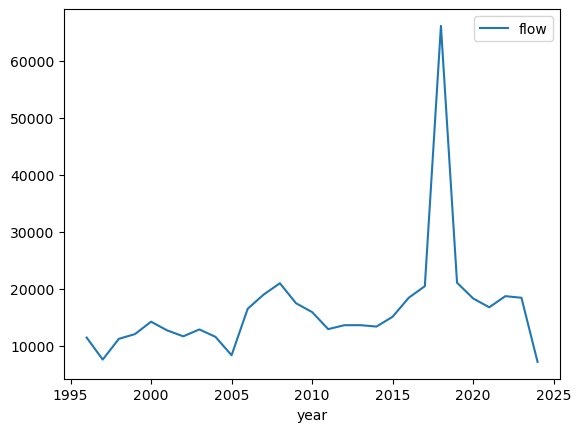

In [185]:
flow.plot(x="year", y="flow")

In [186]:
count_agg_year = count_agg_year[count_agg_year['year']>=1990]

In [195]:
count_agg_year = count_agg_year[count_agg_year['year']<=2017]

In [196]:
count_agg_year = count_agg_year.reset_index()

In [197]:
population = pd.read_csv("data/canada-population.csv") 

In [198]:
count_agg_year['pop']=population[['pop']]

In [199]:
count_agg_year['data'] = count_agg_year['counts']/count_agg_year['pop']

In [200]:
num = count_agg_year.iloc[0]['data']

In [201]:
count_agg_year['data'] = count_agg_year['data']/ num

<Axes: xlabel='year'>

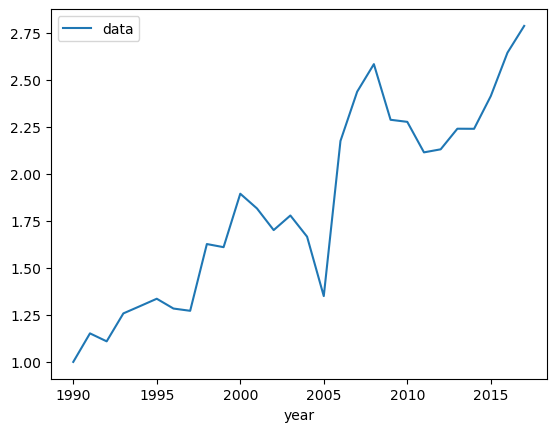

In [202]:
count_agg_year.plot(x="year", y='data')

In [206]:
flow.head(3)

,year,counts_x,disposal_year,counts_y,flow
20,1996,12156.0,1996.0,742.0,11414.0
21,1997,12160.0,1997.0,4610.0,7550.0
22,1998,15689.0,1998.0,4498.0,11191.0


In [204]:
cpc = pd.read_csv("data/g_cpc_at_issue.tsv", sep='\t') 

In [212]:
data2 = pd.merge(data1, cpc, on=['patent_id'])

In [219]:
data2= data2[['year','cpc_section_y']]

In [222]:
data2['year'].unique()

array([2018, 2019, 2023, 2014, 2020, 2016, 2021, 2015, 2022, 2017, 2024,
       2013], dtype=int32)